# **Working memory training**: plotting MLM results on the whole-brain normalized recruitment/integration


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
import numpy as np
import json
import os

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from numpy.ma import masked_array
from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr
from functools import reduce

# Load dataset

## Required files
- `path_cart_raw`: Directory containing raw functional cartography measures for all subjets and sessions:
    - `normalized_mean_allegiance_power.npy`: Integration and recruitment values.
- `path_mlm_summary`: Directory containing results of statistical modeling of cartography measures (subject dimension reduction):
    - `whole-brain_{atlas}_{dataset}_mlm_stats.csv`: Test statistic and p-values.
    - `whole-brain_{atlas}_{dataset}_mlm_params.csv`: Linear coeffient values.
- `path_groups`: Directory containing group assignment table:
    - `group_assignment.csv`
- `path_beh`: Directory containing all behavioral data files:
    - `aggregated_behavioral_data.npy`
    - `aggregated_behavioral_data.json`

## Dataset choice
- `dataset`: Either `normalized` or `raw`.
- `atlas`: Either `power` or `schaefer`.
- `who`: Either `all` for all included subject, `exp` for experimental group or `con` for control group.

In [4]:
# Change if needed
path_cart_raw = '/home/finc/Dropbox/Projects/LearningBrain/data/derivatives/mlm_raw'
path_mlm_summary = '/home/finc/Dropbox/Projects/LearningBrain/data/derivatives/mlm_networks_summary'

# Which dataset to use
dataset = 'normalized'
atlas = 'power'     

# Filenames
fname_cart_raw = f'whole-brain_{atlas}_{dataset}_mean_allegiance_power.npy'
fname_mlm_stats = f'whole-brain_{atlas}_{dataset}_mlm_stats.csv'
fname_mlm_params = f'whole-brain_{atlas}_{dataset}_mlm_params.csv'

In [6]:
cart = np.load(
    os.path.join(path_cart_raw, fname_cart_raw),
    allow_pickle=True)

df_stats = pd.read_csv(os.path.join(path_mlm_summary, fname_mlm_stats), index_col=0)
df_params = pd.read_csv(os.path.join(path_mlm_summary, fname_mlm_params), index_col=0)

# Create LSN labels
if atlas == 'power':
    labels = ['AU', 'CER', 'CO', 'DA', 'DM', 'FP', 'MEM', 
              'SAL', 'SOM', 'SUB', 'UNC', 'VA', 'VIS']
else:
    labels = ['CON', 'DA', 'DM', 'LIM', 'SAL', 'SOM', 'VIS']
    # labels.reverse()

n_lsn = len(labels)

# # Display hint
# for dim in ['dim2', 'dim3', 'dim4', 'dim5']:
#     print(dim, ': ', meta[dim])

# Change data format 

Split data into set of upper-triangular arrays of size $13 \times 13$.

## Multi-level modeling (MLM) comparison arrays 

Represents results of statistical model comparison. First index is coding different models (0: group model; 1: session model; 2: interaction model) while next indices are coding LSNs:

- `chi_mlm`: $\chi^2$ test value for single model evaluation
- `pval_mlm`: corresponding $p$ values 

## Estimated model parameter arrays

Respresents estimated influence of different dependent variables on independent variable (here recruitment or integration). First index is coding different session pairs (0: Naive vs Early; 1: Naive vs Middle; 2: Naive vs Late) while next indices are coding LSN group assignment:

- `beta_ses`: linear regression $\beta$ parameters for session model
- `beta_inter`: linear regression $\beta$ parameters for interaction model

In [7]:
chi_mlm = np.zeros((3, n_lsn, n_lsn))
pval_mlm = np.zeros((3, n_lsn, n_lsn))

for idx, row in df_stats.iterrows():
    
    i, j = int(row.i) - 1, int(row.j) - 1
    
    chi_mlm[0, i, j] = row.chi_group
    chi_mlm[1, i, j] = row.chi_session
    chi_mlm[2, i, j] = row.chi_interaction

    pval_mlm[0, i, j] = row.pval_group
    pval_mlm[1, i, j] = row.pval_session
    pval_mlm[2, i, j] = row.pval_interaction
    
beta_ses = np.zeros((3, n_lsn, n_lsn))
beta_inter = np.zeros((3, n_lsn, n_lsn))

for idx, row in df_params.iterrows():
    
    i, j = int(row.i) - 1, int(row.j) - 1
    
    for ses in range(3):
        beta_ses[ses, i, j] = row[f'beta1{ses+2}_session']
        beta_inter[ses, i, j] = row[f'beta1{ses+2}_interaction']

In [8]:
def correct_pvals_array(pvals, method='fdr_bh'):
    ''' Perform multiple comparison correction on p-values arranged into square
    array. 
    
    Args:
        pvals (array_like): 
            Upper-triangular array of p-values.
        method (str):
            Correction method passed to multipletests function from statsmodels
            library.
            
    Returns
        (array_like): Corrected p-vales. Same dimension as input array.
    '''

    upper_ind = np.triu_indices(pvals.shape[0], k=0)
    pvals_vec = pvals[upper_ind]

    pvals_vec_corrected = multipletests(
        pvals_vec,
        alpha=0.05,
        method=method,
        is_sorted=False,
        returnsorted=False,
        )[1]

    pvals_corrected = np.zeros(pvals.shape)
    pvals_corrected[upper_ind] = pvals_vec_corrected
    return pvals_corrected

def symmetrize(matrix):
    '''Symmetrizes triangular matrix'''
    from warnings import warn

    if np.allclose(matrix, matrix.T):
        warn('matrix is already symmetric')
        return matrix
    else:
        return matrix + matrix.T - np.diag(np.diag(matrix))

# Manage plt.rc settings

In [9]:
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Helvetica'
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=23)    # fontsize of the tick labels
plt.rc('ytick', labelsize=23)    # fontsize of the tick labels
plt.rc('legend', fontsize=15) 
plt.rc('figure', figsize=(10, 10))
plt.rc('axes', linewidth=3)

# Colobar settings
cbar_width = 0.03
cbar_offset = 0.02

# Create custom colormap (diverging black - white - black)
col_gray = (.75, .75, .75)
col_white = (1, 1, 1)
newcmp = LinearSegmentedColormap.from_list(
    'gray_div', 
    [col_gray, col_white, col_gray], 
    N=128)

# Generate figures

In [10]:
def matrix_pval_plot(pvals, cvals, labels, vmin, vmax, outpath=None, **savefig_kwargs) -> None:
    '''Creates matrix plot color coded according to underying p-values. 
    
    Args:
        pvals (array-like): 
            Symmetric matrix of p-values.
        cvals (array-like):
            Corresponding values. These values will actually determine color 
            intensity in heatmap cells.
        labels (list):
            List of labels for both matrix axis. Should have length equal to 
            pvals.shape[0].
        outpath (str)[optional]:
            If specified plot will be saved under path specified in outpath.
        savefig_kwargs (dict)[optional]:
            Optional kwargs passed to fig.savefig() function.
    '''
    # Correct p-values if needed
    pvals_corrected = symmetrize(correct_pvals_array(pvals))
    cvals_sig = masked_array(symmetrize(cvals), symmetrize(pvals) > .05)

    fig, ax = plt.subplots(facecolor='w')

    # Manage labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Plot heatmaps
    clim = [-np.max(np.abs(cvals_sig)), np.max(np.abs(cvals_sig))]
    im_sig = ax.imshow(cvals_sig, cmap='RdBu_r', clim=clim, vmin = vmin, vmax = vmax)

    # Create colorbars
    cb_sig_axes = fig.add_axes(
        [ax.get_position().x1 + cbar_offset, ax.get_position().y0,
         cbar_width, ax.get_position().height])
    cb_sig = plt.colorbar(im_sig, cax=cb_sig_axes)

    # Annotate significant p-vals (FDR corrected)
    ind_corrected = np.nonzero((pvals_corrected < 0.05) * (pvals_corrected != 0))

    for i, j in zip(*ind_corrected):
        ax.text(j, i + .11, '*', ha="center", va="center", color="w", 
                fontsize=22, fontweight='bold')

    plt.plot()

    if outpath:
        fig.savefig(outpath, **savefig_kwargs)

### Figures description

- Colored tiles represent significant uncorrected effect ($p < 0.05$).
- Astrerisks represent significant corrected effect ($p_{FDR} < 0.05$).
- For MLM statistics color is coding estimated $\beta$ parameter for change between Naive and other sessions.
- For brain-behavior correlations color is coding correlation coefficient $\rho$.

#### Figure 1.
Significant effects for group model.

#### Figure 2.
Significant effects for interaction model.

In [11]:
def reorder(mat, new_order):
    return mat[:, new_order][new_order]

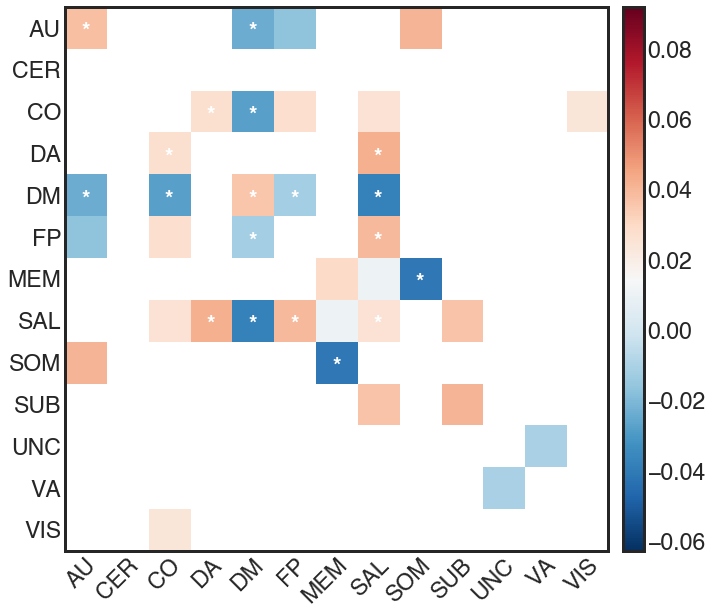

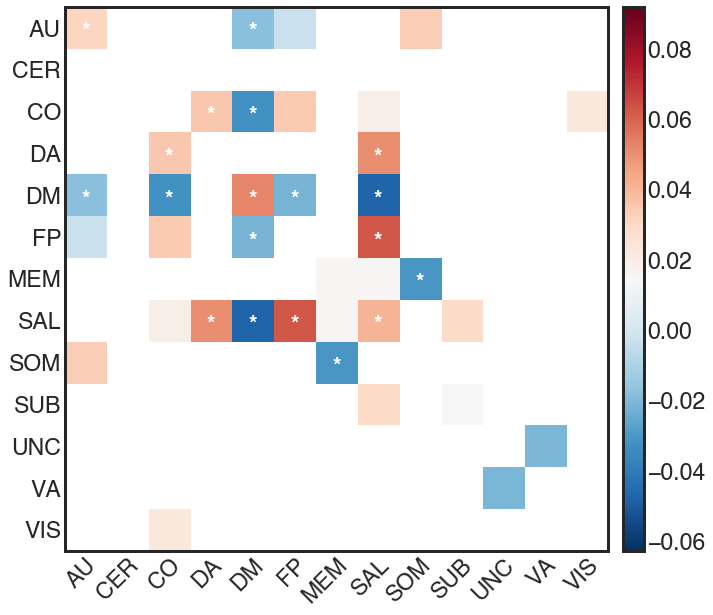

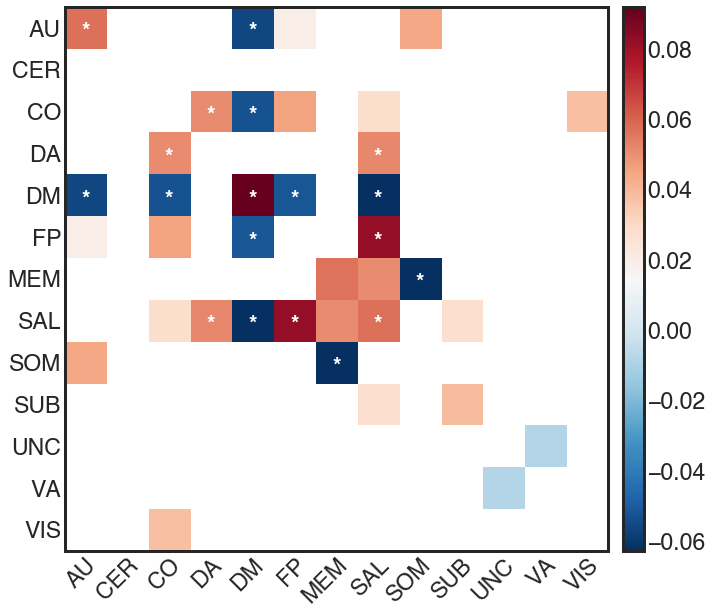

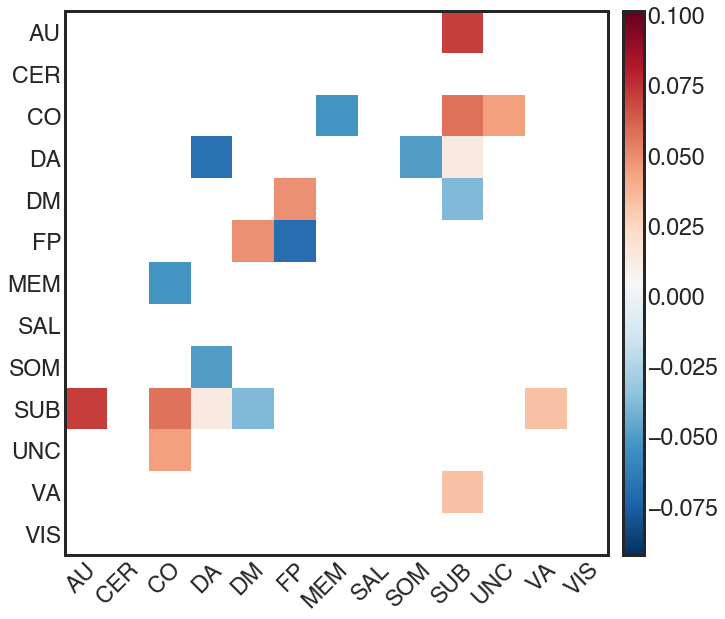

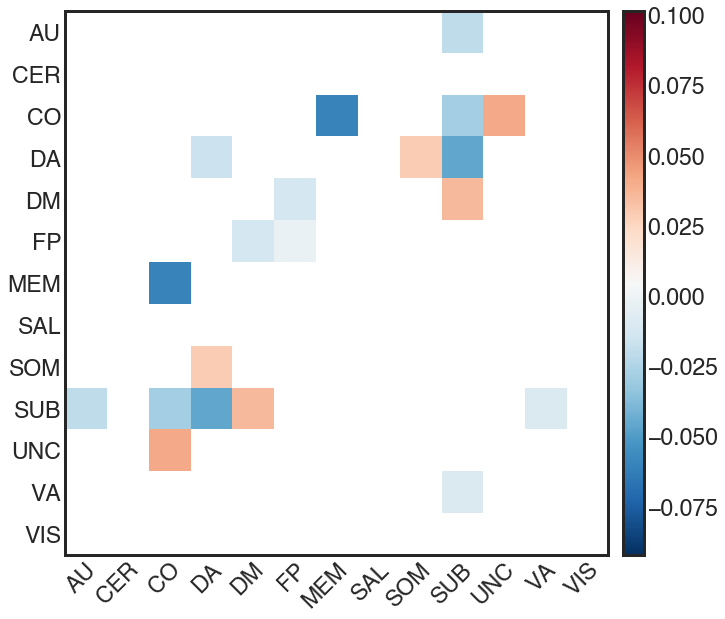

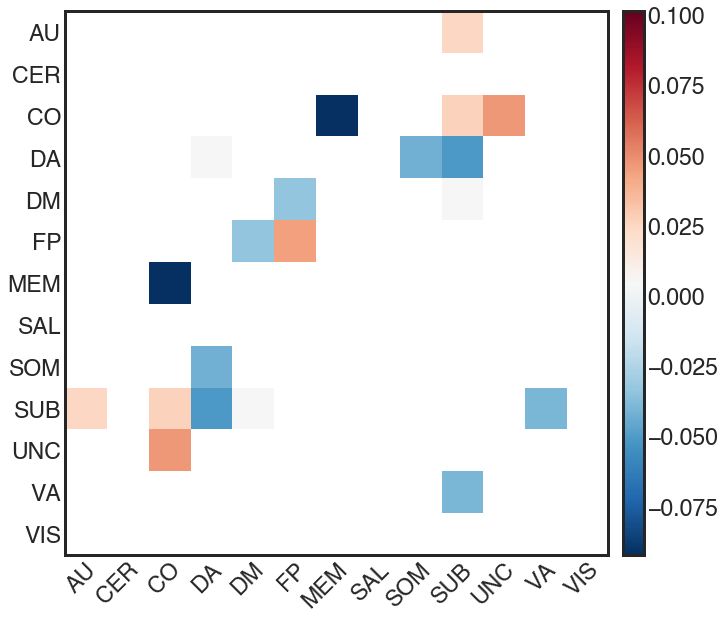

In [12]:
for i in range(3):
    matrix_pval_plot(
        pval_mlm[1], 
        beta_ses[i], 
        labels, 
        vmax=beta_ses.max(),
        vmin=beta_ses.min(),
        outpath=f'mlm_session_{dataset}_{atlas}_{i+1}.pdf', 
        bbox_inches='tight'
    )
    
for i in range(3):
    matrix_pval_plot(
        pval_mlm[2],
        beta_inter[i],
        labels, 
        vmax=beta_inter.max(),
        vmin=beta_inter.min(),
        outpath=f'mlm_interaction_{dataset}_{atlas}_{i+1}.pdf',
        bbox_inches='tight'
    )

# Corralation with behavior
## Brain part
Assumptions:

1. Use only network pairs for which significant changes was observed for either group or interaction model (this implies that only group level correlations should be verified).
2. Use only differences in integration and recruitment between from Naive to Early, and Naive and Late sessions.

Variables:
- `delta_net`: Change in integration / recruitment from Naive to Early, and Naive to Late session.

## Behavioral part
Assumptions:

1. Use only behavioral measures of d-prime ans pRT.
2. For each subject and session average performance measure over stimuli modalities.
3. Use difference between 1-back and 2-back performance
3. Use only the difference in behavioral measures between Naive and Early, and Naive and Late sessions

# Show correlation

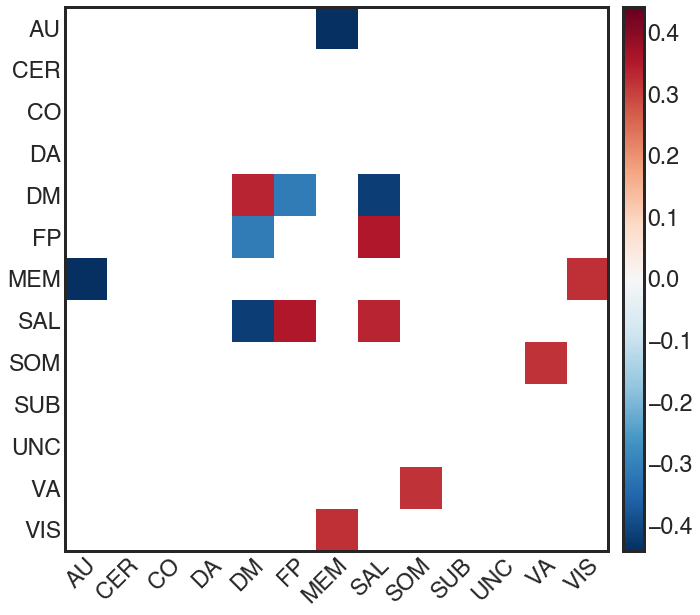

In [14]:
correlation = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/correlation_naive_late_all.csv')

corr = np.zeros((n_lsn, n_lsn))
pval_corr = np.zeros((n_lsn, n_lsn))

for idx, row in correlation.iterrows():   
    i, j = int(row.i) - 1, int(row.j) - 1
    corr[i, j] = row.pval
    pval_corr[i, j] = row.estimate

    
matrix_pval_plot(
    corr, 
    pval_corr, 
    labels, 
    vmin=None,
    vmax=None,
    outpath=f'corr_{dataset}_{atlas}_naive_late_all_dprime.pdf', 
    bbox_inches='tight'
)